### This notebook contains the base codes used in many of the scripts and answers to questions. The individual scripts are in a folder named "scripts." 

#### Question 1:

In [2]:
## Imports the required libraries 

from scipy.stats import chi2 as chi2_scp
from cosmopower import cosmopower_NN
from getdist import plots, MCSamples
from IPython.display import Image
import matplotlib.pyplot as plt
from numpy.linalg import inv
import tensorflow as tf
import numpy as np
import emcee
import gc

# Sets a random seed for reproducible results 
np.random.seed(100)

In [4]:
## Loads-in all required data 

reference_model_noisy = np.load("reference_model_noise.npy")
parameters = np.load("parameters.npz") 
cov = np.load("covariance.npy")
models = np.load("models.npy")

# Computes the inverse of the analytical covariance matrix 
cov_inv = inv(cov)

# Restores the trained model 
cp_nn_model = cosmopower_NN(restore = True, restore_filename = "emulator_final")
train_sample = np.arange(0, 7000)
# Selects the model data rows for training
train_features = np.load("models.npy")[train_sample] # Note: this slicing is unnecessary, but was taken 
                                                     # from the MCMC notebook
minimum = np.min(train_features, axis = 0)
maximum = np.max(train_features - minimum, axis = 0)

In [3]:
list(parameters.keys())

['omega_m', 'omega_b', 'As', 'w']

In [5]:
# Specifies the length of the MCMC chain 
nsteps = 5000  
# Specifies the number of walkers in the MCMC chain 
nwalkers = 35
# Specifies the number of dimensions (4 since we are varying 4 parameters)
ndim = 4

## Computes various parameter values 

omega_m_vals = parameters["omega_m"]
omega_b_vals = parameters["omega_b"]
As_vals = parameters["As"]
w_vals = parameters["w"]

## Specifies prior bounds for all parameters

omega_m_bounds = [min(omega_m_vals), max(omega_m_vals)]
omega_b_bounds = [min(omega_b_vals), max(omega_b_vals)]
As_bounds = [min(As_vals), max(As_vals)]
w_bounds = [min(w_vals), max(w_vals)]
bounds = [omega_m_bounds, omega_b_bounds, As_bounds, w_bounds]

# Initiates an array that will contain different starting positions 
pos = np.empty((nwalkers, ndim))

for i in range(ndim):
    # Computes positions within a prior range according to a uniform distribution 
    vals = np.random.uniform(bounds[i][0], bounds[i][1], nwalkers)
    pos[:, i] = vals
    
def log_probability(theta):
    """
    Computes the log probability of certain parameter combinations. 
    """
    
    omega_m, omega_b, As, w = theta 
    
    # Checks if the parameter values are within their prior ranges 
    if omega_m_bounds[0] < omega_m < omega_m_bounds[1] and omega_b_bounds[0] < omega_b < omega_b_bounds[1] and As_bounds[0] < As < As_bounds[1] and w_bounds[0] < w < w_bounds[1]:
        
        # Makes a dictionary of parameter values 
        params = {"omega_m": [omega_m], "omega_b": [omega_b], "As": [As], "w": [w]}
        
        # Predicts the output of this parameter combination using the emulator 
        pred_vector = cp_nn_model.predictions_np(params)[0]
        pred_vector = pred_vector * maximum + minimum
        delta = pred_vector - reference_model_noisy
        # Compues the log probability, which is -chi^2 / 2
        likelihood = -0.5 * np.matmul(delta, np.matmul(cov_inv, delta))
        return likelihood
    
    # If a parameter is outside its prior range, then the log probability is - infinity 
    else: 
        return -np.inf 

In [6]:
# Initializes the walkers 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
# Runs the MCMC 
sampler.run_mcmc(pos, nsteps, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:50<00:00,  7.69it/s]


State([[ 3.53194506e-01  4.63810918e-02  2.02739517e-09 -1.09883502e+00]
 [ 3.52538762e-01  4.69590281e-02  2.02815974e-09 -1.12302174e+00]
 [ 3.54532424e-01  4.89054952e-02  2.05775043e-09 -1.10224588e+00]
 [ 3.51015023e-01  4.68663055e-02  2.04970195e-09 -1.13434301e+00]
 [ 3.55516609e-01  4.85880826e-02  2.03656932e-09 -1.10508045e+00]
 [ 3.46316771e-01  4.34852087e-02  2.00035464e-09 -1.16592350e+00]
 [ 3.53845662e-01  4.48849959e-02  1.96360620e-09 -1.12284296e+00]
 [ 3.45494279e-01  4.29512311e-02  1.98397024e-09 -1.20735946e+00]
 [ 3.50626446e-01  5.08255783e-02  2.13129287e-09 -1.14855677e+00]
 [ 3.49303416e-01  4.99111061e-02  2.12569784e-09 -1.14076437e+00]
 [ 3.44991789e-01  4.40732657e-02  2.03398562e-09 -1.15851730e+00]
 [ 3.55042746e-01  4.93625601e-02  2.06759035e-09 -1.11733507e+00]
 [ 3.54573601e-01  4.91737850e-02  2.06745617e-09 -1.09468813e+00]
 [ 3.58977135e-01  5.42433122e-02  2.13810876e-09 -1.07512726e+00]
 [ 3.48273633e-01  4.48133138e-02  2.00583699e-09 -1.156

In [7]:
print("Mean acceptance fraction:", sampler.acceptance_fraction)
# Computes the autocorrelation time 
tau = sampler.get_autocorr_time(tol = 0)
print("Autocorrelation time:", tau) 
# Retrieves the parameter values for each walker at each step 
samples = sampler.get_chain()

Mean acceptance fraction: [0.5966 0.5928 0.5998 0.5862 0.5962 0.5976 0.5776 0.6018 0.5916 0.5834
 0.5976 0.6088 0.5896 0.5986 0.5826 0.5884 0.5944 0.593  0.598  0.5888
 0.6006 0.5966 0.5954 0.582  0.5922 0.5846 0.5832 0.6024 0.5974 0.592
 0.5752 0.5982 0.603  0.587  0.5976]
Autocorrelation time: [26.68165303 42.3325968  41.90167215 37.38351326]


Text(0.5, 0, 'Step Number')

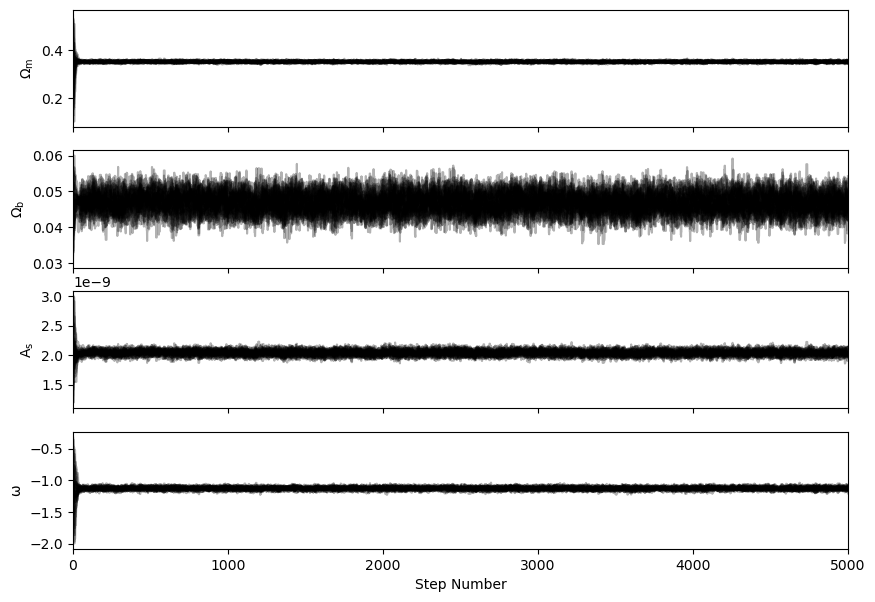

In [8]:
## Plots the parameter values for each walker at each step 

labels = [r"$\mathrm{\Omega_m}$", r"$\mathrm{\Omega_b}$", r"$\mathrm{A_s}$", 
          r"$\mathrm{\omega}$"]
fig, axes = plt.subplots(4, figsize = (10, 7), sharex = True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("Step Number")

Removed no burn in


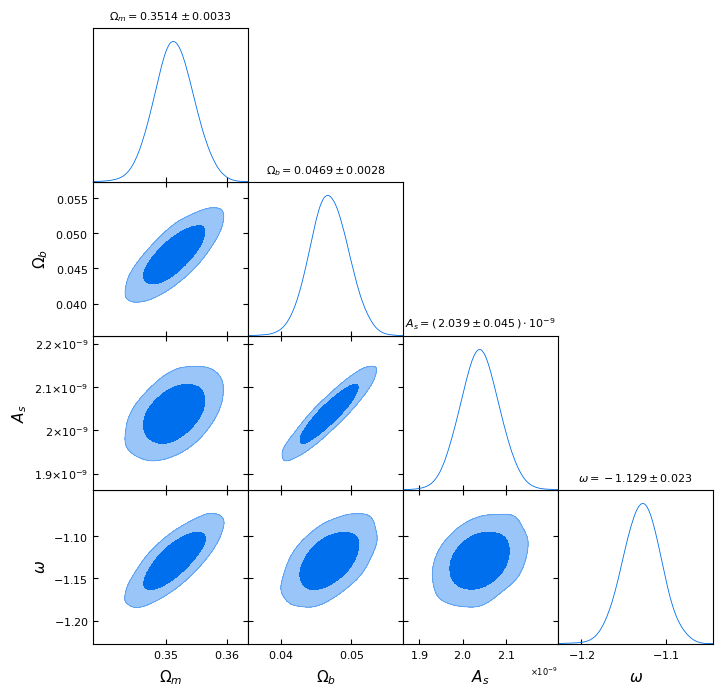

In [9]:
# Discards the burn-in steps, thins the chain, and flattens it 
flat_samples = sampler.get_chain(discard = 200, thin = 25, flat = True) 

## Plots the posterior probability distributions 

# Defines the parameter names/labels 
names = ["\Omega_m", "\Omega_b", "A_s", "\omega"]
samples = MCSamples(samples = flat_samples, names = names, labels = names)
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled = True, title_limit = 1)

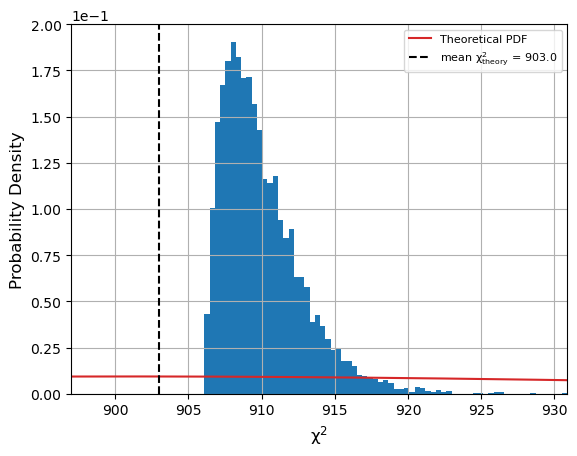

In [10]:
# Retrieves the flattened log probabilities from the chain 
log_prob_samples = sampler.get_log_prob(discard = 200, thin = 25, flat = True)
# Computes the chi-squared values from the log probabilities 
chi2 = -2 * log_prob_samples

x_data = np.linspace(897, max(chi2), num = 10000)
# Computes the degrees of freedom (dof). Note: 4 is added to the dof since 4 parameters are 
# varied 
dof = len(reference_model_noisy) - 1 + 4
# Computes the theoretical mean and variance of the chi-squared distribution 
mean, var = chi2_scp.stats(dof, moments = "mv")

## Plots a histogram of the chi-squared values and the theoretical pdf

plt.hist(chi2, bins = "fd", density = True, color = "tab:blue")
# Computes the theoretical chi-squared distribution 
plt.plot(x_data, chi2_scp.pdf(x_data, dof), color = "tab:red", label = "Theoretical PDF")
plt.vlines(mean, 0, 0.2, label = "mean " + r"$\mathrm{\chi_{theory}^{2}}\,=\,$" + str(mean), 
           linestyle = "--", color = "k")
plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
plt.ylabel("Probability Density", fontsize = 12)
plt.xlim(897, max(chi2))
plt.ylim(0, 0.2)
# Uses scientific notation on the y-axis
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
plt.legend(loc = "best", fontsize = 8)
plt.grid()
plt.show()

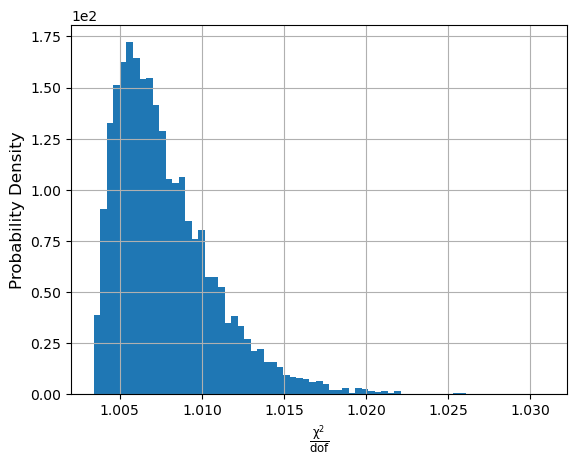

In [11]:
## Plots the REDUCED chi-squared distrubution 

plt.hist(chi2 / dof, bins = "fd", density = True, color = "tab:blue")
plt.xlabel(r"$\mathrm{\frac{\chi^2}{dof}}$", fontsize = 12)
plt.ylabel("Probability Density", fontsize = 12)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
plt.grid()
plt.show()

Remarks: 

- The chain's length should be greater than or equal to 50 times the integrated autocorrelation time (steps needed for the chain to forget where it started) to trust results/assume convergence. Here, that requirement is satisfied since the autocorrelation times do not exceed 50, and the chain's length is 5000 

- The mean acceptance fraction (fraction of proposed steps that are accepted) hovers around 0.6, which is a "normal" mean acceptance fraction. For each run, the autocorrelation time and mean acceptance fraction are computed to confirm that the sampling went well

- The steps each walker takes are plotted. These plots confirm there were no walkers that went astray or got stuck at "weird" parameter values 

- The posterior distributions are Gaussian/look "normal." This is also the case for all posterior distributions below

- The reduced chi-squared distribution peaks somewhere between 1.005 and 1.01. If the model being fit to data points is good, then we expect the reduced chi-squared to be very close to 1. Here, the reduced chi-squared values are not significantly greater than 1, which is reassuring. However, the chi-squared distribution differs a lot from the theoretical chi-squared distribution

#### Question 2:

In this question, the analytical covariance matrix was replaced with different numerical covariance matrices. The code that debiased the covariance matrix with the Hartlap factor looks like the following:

In [ ]:
cov = np.load("cov_num_1500.npy")
# Computes the Hartlap factor 
h_1500 = (1500 - 1) / (1500 - len(reference_model_noisy) - 2)
# Computes the debiased inverse of the covariance matrix 
cov_inv = inv(cov) / h_1500

MCMC results:

In [13]:
# Loads-in the flat samples for the 1500 covariance matrix without Hartlap factor correction
flat_samples_1500 = np.load("Q2_1500_flat_samples.npy")
# Loads-in the flattened log probabilities for the 1500 covariance matrix without Hartlap
# factor correction 
log_prob_samples_1500 = np.load("Q2_1500_log_prob_samples.npy")
flat_samples_3000 = np.load("Q2_3000_flat_samples.npy")
log_prob_samples_3000 = np.load("Q2_3000_log_prob_samples.npy")
flat_samples_10000 = np.load("Q2_10000_flat_samples.npy")
log_prob_samples_10000 = np.load("Q2_10000_log_prob_samples.npy")

# Loads-in the flat samples for the 1500 covariance matrix WITH Hartlap factor correction
flat_samples_hartlap_1500 = np.load("Q2_1500_hartlap_flat_samples.npy")
log_prob_samples_hartlap_1500 = np.load("Q2_1500_hartlap_log_prob_samples.npy")
flat_samples_hartlap_3000 = np.load("Q2_3000_hartlap_flat_samples.npy")
log_prob_samples_hartlap_3000 = np.load("Q2_3000_hartlap_log_prob_samples.npy")
flat_samples_hartlap_10000 = np.load("Q2_10000_hartlap_flat_samples.npy")
log_prob_samples_hartlap_10000 = np.load("Q2_10000_hartlap_log_prob_samples.npy")

names = ["\Omega_m", "\Omega_b", "A_s", "\omega"]

sample_1 = MCSamples(samples = flat_samples_1500, names = names, labels = names, 
                     label = "1500 Covariance Matrix")
sample_2 = MCSamples(samples = flat_samples_3000, names = names, labels = names, 
                     label = "3000 Covariance Matrix")
sample_3 = MCSamples(samples = flat_samples_10000, names = names, labels = names, 
                     label = "10,000 Covariance Matrix")
sample_4 = MCSamples(samples = flat_samples_hartlap_1500, names = names, 
                     labels = names, label = "1500 Covariance Matrix\nWith Hartlap Correction\n")
sample_5 = MCSamples(samples = flat_samples_hartlap_3000, names = names, 
                     labels = names, label = "3000 Covariance Matrix\nWith Hartlap Correction\n")
sample_6 = MCSamples(samples = flat_samples_hartlap_10000, names = names, 
                     labels = names, label = "10,000 Covariance Matrix\nWith Hartlap Correction")

chi2_1500 = -2 * log_prob_samples_1500
chi2_3000 = -2 * log_prob_samples_3000
chi2_10000 = -2 * log_prob_samples_10000

chi2_hartlap_1500 = -2 * log_prob_samples_hartlap_1500
chi2_hartlap_3000 = -2 * log_prob_samples_hartlap_3000
chi2_hartlap_10000 = -2 * log_prob_samples_hartlap_10000

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


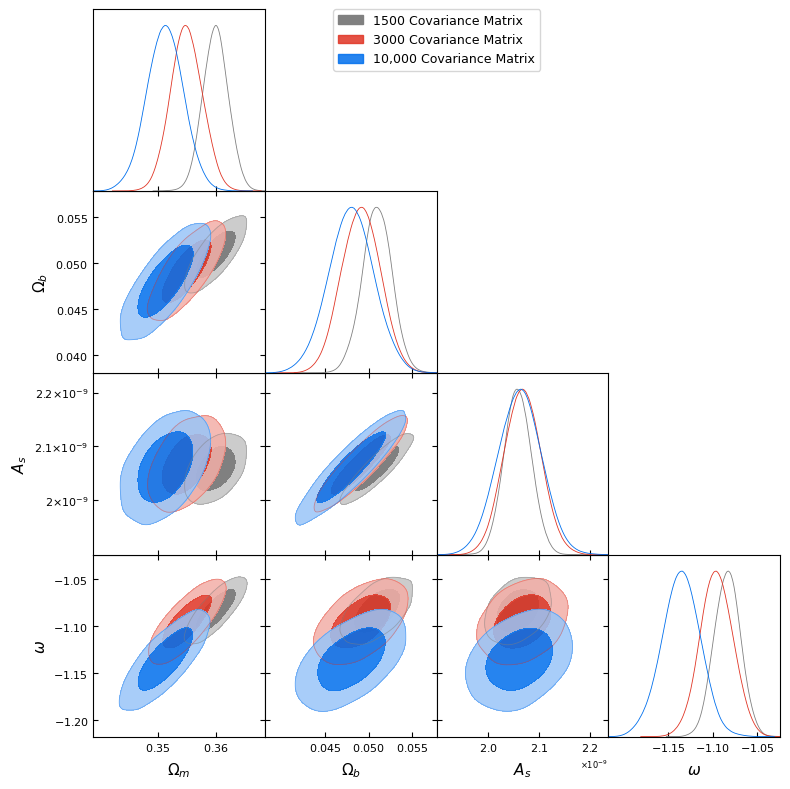

In [14]:
g = plots.get_subplot_plotter()
# Plots the posterior distributions for all numerical covariance matrices without Hartlap factor 
# correction 
g.triangle_plot([sample_1, sample_2, sample_3], filled = True)

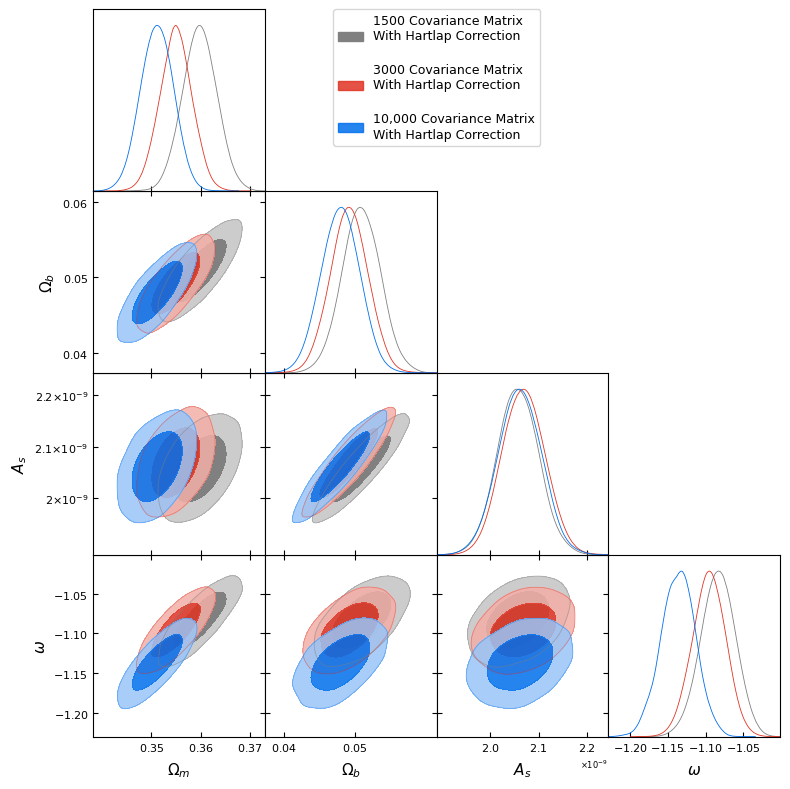

In [6]:
# Plots the posterior distributions for all numerical covariance matrices WITH Hartlap factor 
# correction 
g.triangle_plot([sample_4, sample_5, sample_6], filled = True)

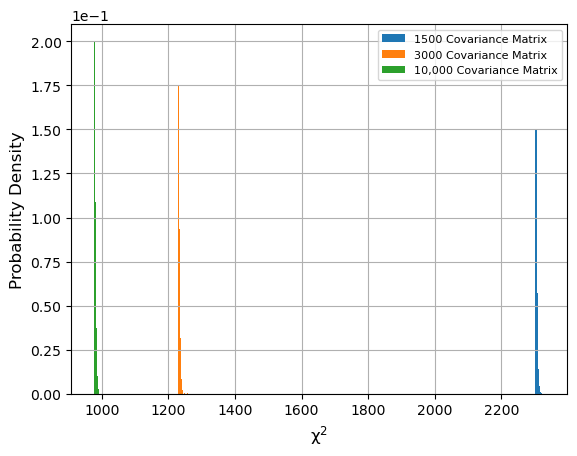

In [7]:
## Plots the chi-squared distributions for all numerical covariance matrices without Hartlap 
## factor correction 

for chi2_dist, label in zip([chi2_1500, chi2_3000, chi2_10000], ["1500 Covariance Matrix", 
                                                                 "3000 Covariance Matrix",
                                                                 "10,000 Covariance Matrix"]):
    plt.hist(chi2_dist, bins = "fd", density = True, label = label)
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(loc = "upper right", fontsize = 8)
plt.grid()
plt.show()

Additional remark: as the covariance matrix uses more data vectors, the reduced chi-squared gets closer to 1, indicating a better fit to data. 

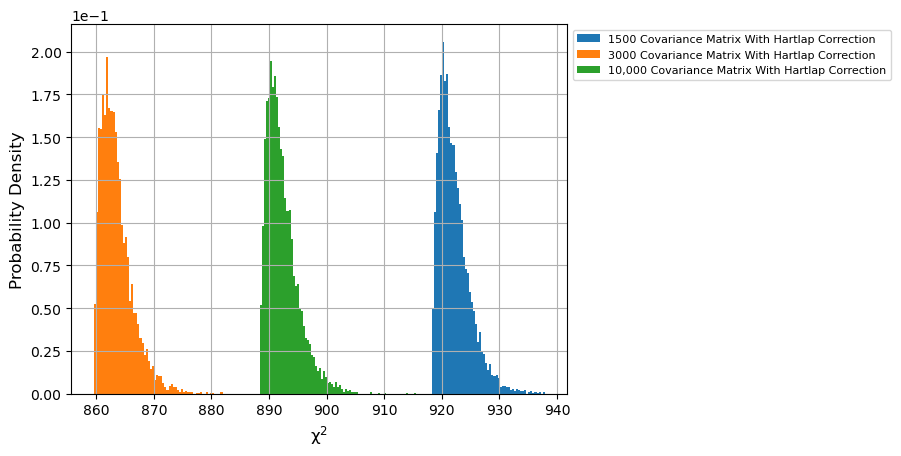

In [8]:
## Plots the chi-squared distributions for all numerical covariance matrices WITH Hartlap 
## factor correction 

for chi2_dist, label in zip([chi2_hartlap_1500, chi2_hartlap_3000, chi2_hartlap_10000], 
                            ["1500 Covariance Matrix With Hartlap Correction", 
                             "3000 Covariance Matrix With Hartlap Correction", 
                             "10,000 Covariance Matrix With Hartlap Correction"]):
    plt.hist(chi2_dist, bins = "fd", density = True, label = label)
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
plt.grid()
plt.show()

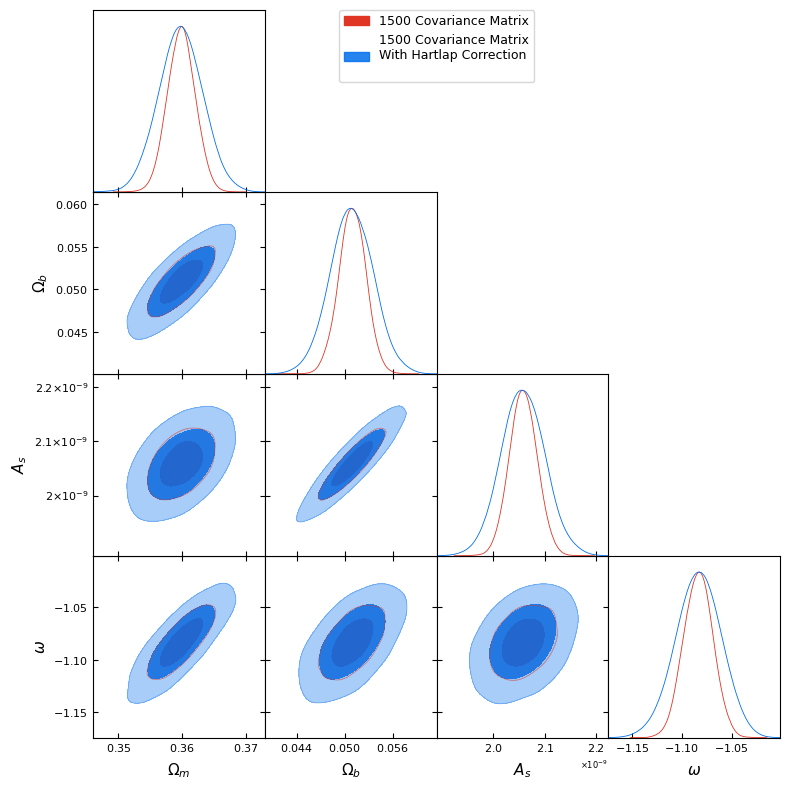

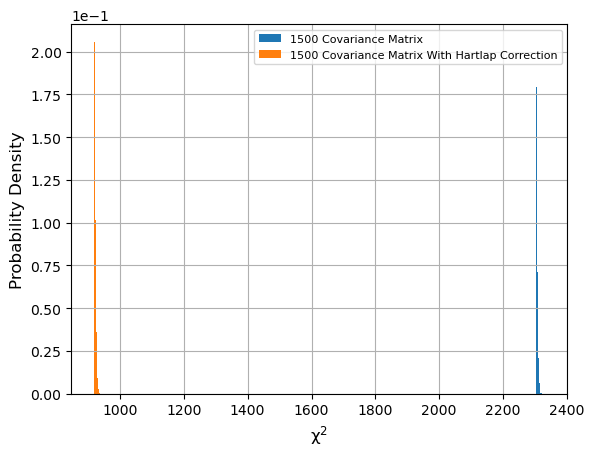

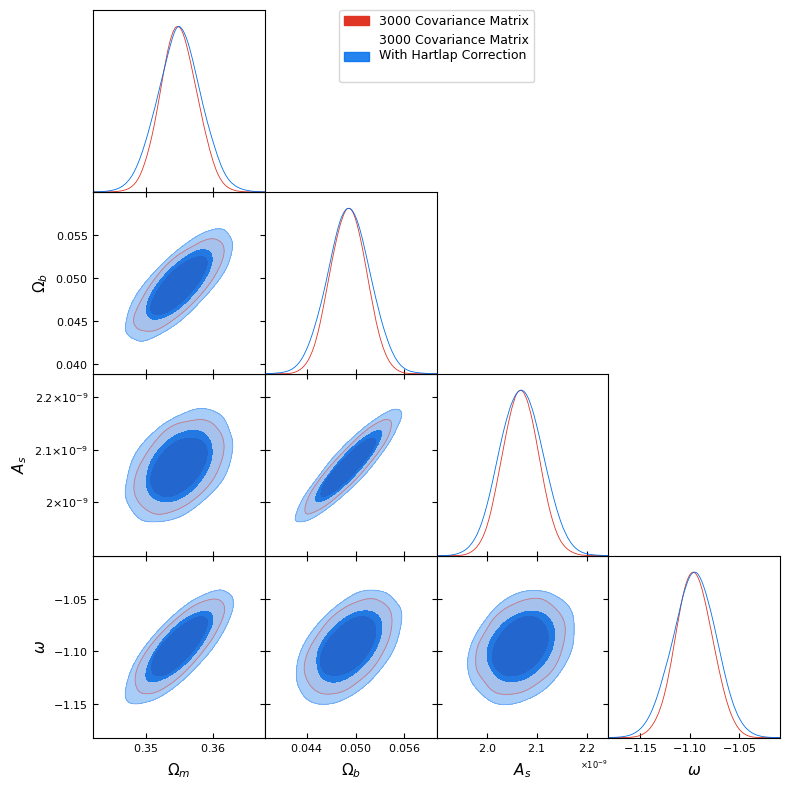

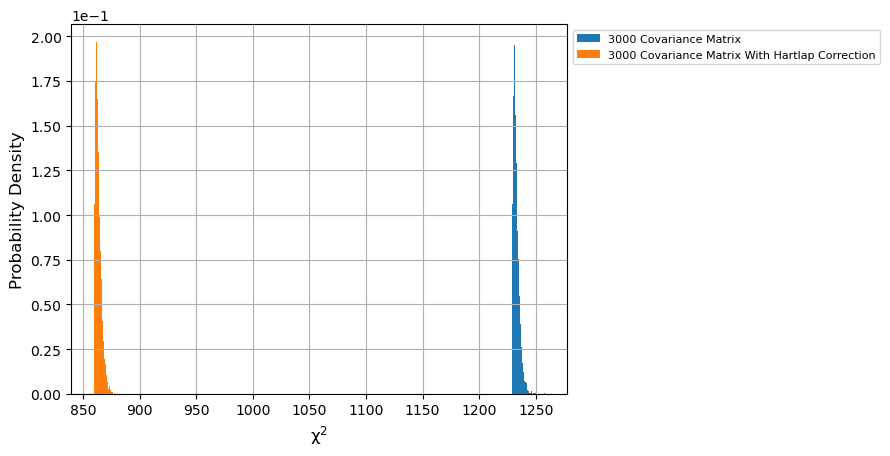

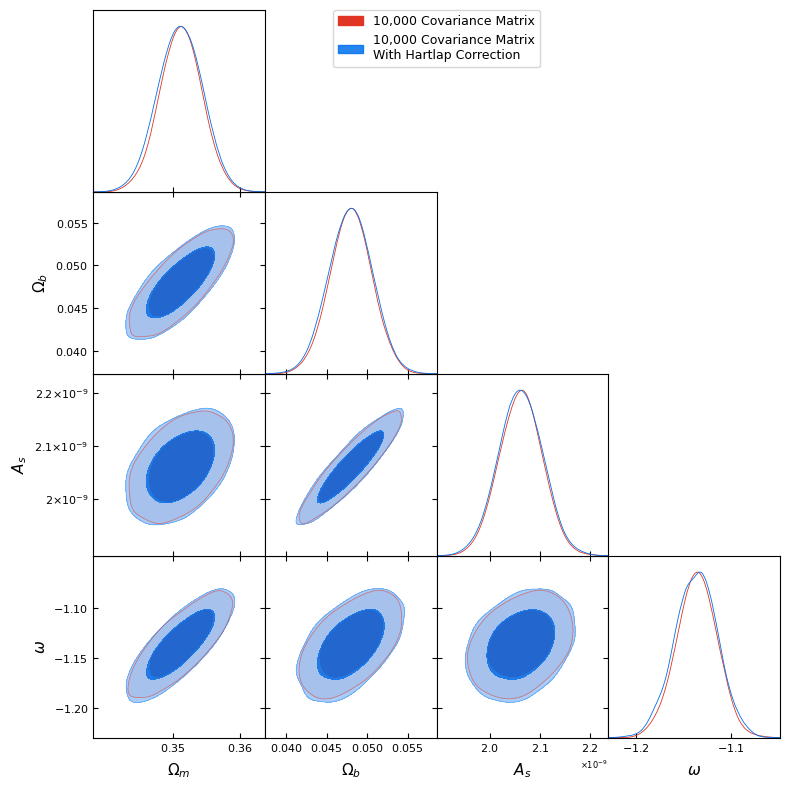

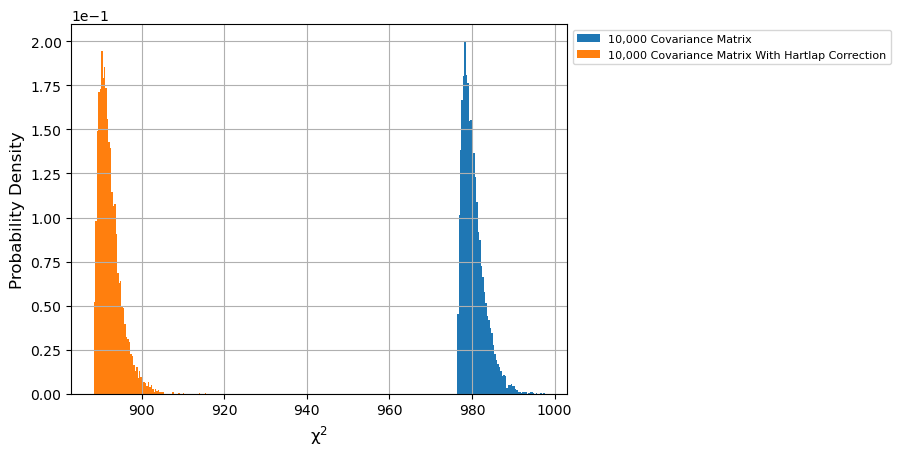

In [9]:
## Plots the posterior and chi-squared distributions for a given numerical covariance matrix 

for samples, chi2_dists, labels in zip([[sample_1, sample_4], 
                                        [sample_2, sample_5], 
                                        [sample_3, sample_6]], 
                                       [[chi2_1500, chi2_hartlap_1500], 
                                        [chi2_3000, chi2_hartlap_3000], 
                                        [chi2_10000, chi2_hartlap_10000]], 
                                       [["1500 Covariance Matrix", 
                                         "1500 Covariance Matrix With Hartlap Correction"], 
                                        ["3000 Covariance Matrix", 
                                         "3000 Covariance Matrix With Hartlap Correction"], 
                                        ["10,000 Covariance Matrix", 
                                         "10,000 Covariance Matrix With Hartlap Correction"]]):
    g.triangle_plot([samples[0], samples[1]], filled = True)
    plt.show()
    plt.hist(chi2_dists[0], bins = "fd", density = True, label = labels[0])
    plt.hist(chi2_dists[1], bins = "fd", density = True, label = labels[1])
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
    plt.grid()
    plt.show()

As can be seen from the plots above, the runs with and without Hartlap factor correction estimate the same best-fit values (comparing covariance matrices with the same data vectors). Phrased differently, the posterior distributions are centered around the same values whether or not Hartlap factor correction was used. However, the widths of these distributions are larger when Hartlap factor correction is used, which is especially noticable when the number of data vectors is small. Also, the chi-squared distribution gets shifted down the x-axis when Hartlap factor correction is used. This result makes sense; it is well known that ignoring the Hartlap factor can lead to an overestimation of the chi-squared distribution. Lastly, the error for a particular parameter remains consistent regardless of the number of data vectors when Hartlap factor correction is used. This is not the case for the runs without Hartlap factor correction.

These results are consistent with Assignment 1. In Assignment 1, we saw that when our covariance matrices were debiased with the Hartlap factor, the chi-squared distributions were shifted down the x-axis. Also, there was less variance in the variance of the chi-squared distributions compared to trials without Hartlap factor correction. 

#### Question 3:

In this question, we ran MCMC for 50, 100, 600, and 900 PCA elements. These runs were completed using the analytical covariance matrix and the covariance matrix with 1500 data vectors (includes Hartlap factor correction). The code that does the PCA data compression looks like the following:

In [ ]:
# Computes the mean of our models for each column. This will be subtracted from "models" for numerical 
# stability
mean = np.mean(models, axis = 0) 
# Defines the number of PCA eigenvalues 
N_pca = 50
# Performs the dimensionality reduction 
pca = PCA(n_components = N_pca, svd_solver = "full")
# Performs the PCA fitting 
models_pca = pca.fit_transform(models - mean) 
# Rotates the covariance matrix 
rotation_matrix = pca.components_.T
# Computes the PCA covariance matrix 
cov_pca = np.matmul(rotation_matrix.T, np.matmul(cov, rotation_matrix))
# Computes the Hartlap factor (only valid for numerical covariance matrices)
h_1500 = (1500 - 1) / (1500 - N_pca - 2)
# Computes the debiased inverse of the PCA covariance matrix
cov_pca_inv = inv(cov_pca) / h_1500
.
.
.
        
        delta = pred_vector - reference_model_noisy
        # Applies a dimensionality reduction to delta 
        delta = (pca.transform([delta])).flatten()                        
.      
.
.

#### 3a)

MCMC results:

In [12]:
flat_samples_50_a = np.load("Q3a_50_flat_samples.npy")
log_prob_samples_50_a = np.load("Q3a_50_log_prob_samples.npy")
flat_samples_100_a = np.load("Q3a_100_flat_samples.npy")
log_prob_samples_100_a = np.load("Q3a_100_log_prob_samples.npy")
flat_samples_600_a = np.load("Q3a_600_flat_samples.npy")
log_prob_samples_600_a = np.load("Q3a_600_log_prob_samples.npy")
flat_samples_900_a = np.load("Q3a_900_flat_samples.npy")
log_prob_samples_900_a = np.load("Q3a_900_log_prob_samples.npy")

sample_1_a = MCSamples(samples = flat_samples_50_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 50, Analytical Covariance Matrix")
sample_2_a = MCSamples(samples = flat_samples_100_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 100, Analytical Covariance Matrix")
sample_3_a = MCSamples(samples = flat_samples_600_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 600, Analytical Covariance Matrix")
sample_4_a = MCSamples(samples = flat_samples_900_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 900, Analytical Covariance Matrix")
                         
chi2_50_a = -2 * log_prob_samples_50_a
chi2_100_a = -2 * log_prob_samples_100_a
chi2_600_a = -2 * log_prob_samples_600_a
chi2_900_a = -2 * log_prob_samples_900_a

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


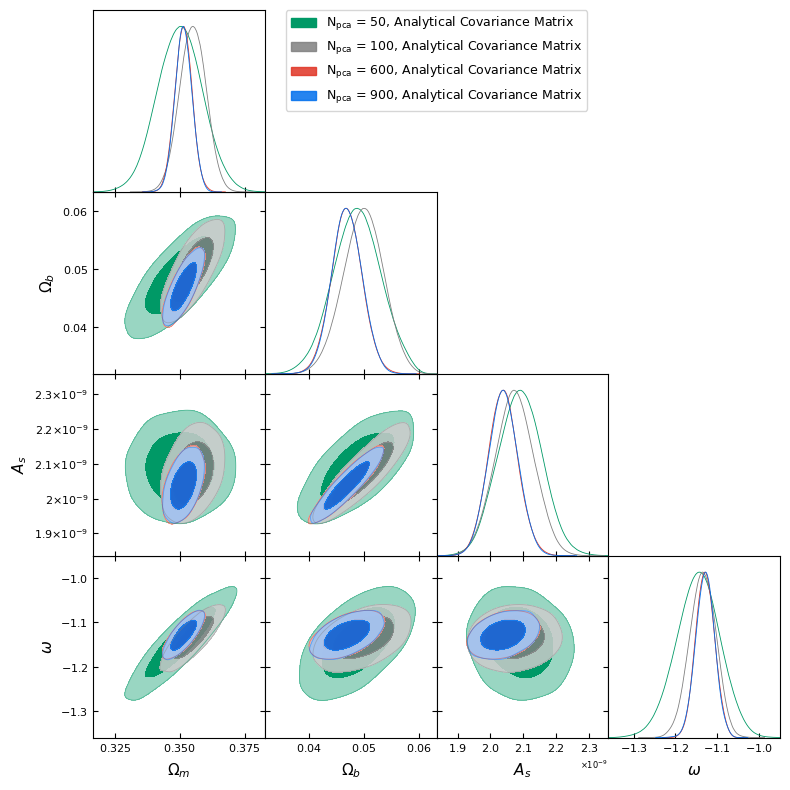

In [11]:
# Plots the posterior distributions for different N_pca using the same analytical covariance 
# matrix
g.triangle_plot([sample_1_a, sample_2_a, sample_3_a, sample_4_a], filled = True)

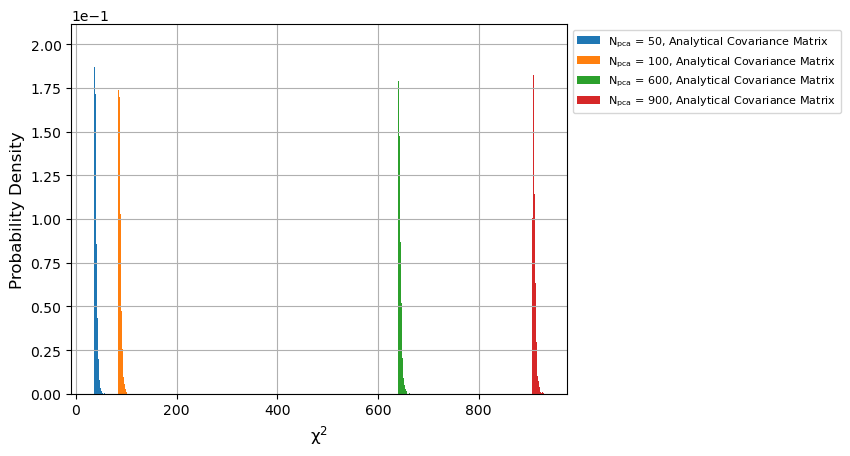

In [12]:
## Plots the chi-squared distributions for different N_pca using the same analytical covariance 
## matrix

for chi2_dist, label in zip([chi2_50_a, chi2_100_a, chi2_600_a, chi2_900_a], 
                            [r"$\mathrm{N_{pca}}$" + " = 50, Analytical Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 100, Analytical Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 600, Analytical Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 900, Analytical Covariance Matrix"]):
    plt.hist(chi2_dist, bins = "fd", density = True, label = label)
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
plt.grid()
plt.show()

Additional remarks: looking at the plot above, we see that smaller N_pca produce chi-squared distributions that are closer to zero. This result makes sense as less PCA elements means less degrees of freedom, which makes the chi-squared distributions peak at smaller values. 

#### 3b)

MCMC results:

In [13]:
flat_samples_50_b = np.load("Q3b_50_flat_samples.npy")
log_prob_samples_50_b = np.load("Q3b_50_log_prob_samples.npy")
flat_samples_100_b = np.load("Q3b_100_flat_samples.npy")
log_prob_samples_100_b = np.load("Q3b_100_log_prob_samples.npy")
flat_samples_600_b = np.load("Q3b_600_flat_samples.npy")
log_prob_samples_600_b = np.load("Q3b_600_log_prob_samples.npy")
flat_samples_900_b = np.load("Q3b_900_flat_samples.npy")
log_prob_samples_900_b = np.load("Q3b_900_log_prob_samples.npy")

sample_1_b = MCSamples(samples = flat_samples_50_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 50, 1500 Covariance Matrix")
sample_2_b = MCSamples(samples = flat_samples_100_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 100, 1500 Covariance Matrix")
sample_3_b = MCSamples(samples = flat_samples_600_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 600, 1500 Covariance Matrix")
sample_4_b = MCSamples(samples = flat_samples_900_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 900, 1500 Covariance Matrix")
                         
chi2_50_b = -2 * log_prob_samples_50_b
chi2_100_b = -2 * log_prob_samples_100_b
chi2_600_b = -2 * log_prob_samples_600_b
chi2_900_b = -2 * log_prob_samples_900_b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


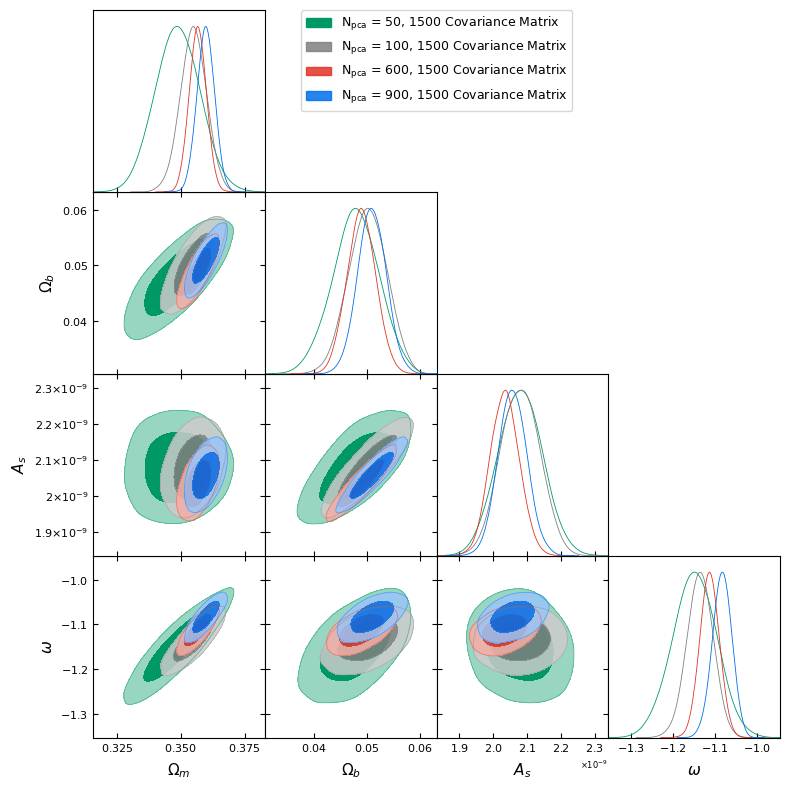

In [14]:
# Plots the posterior distributions for different N_pca using the same covariance matrix 
# with 1500 data vectors 
g.triangle_plot([sample_1_b, sample_2_b, sample_3_b, sample_4_b], filled = True)

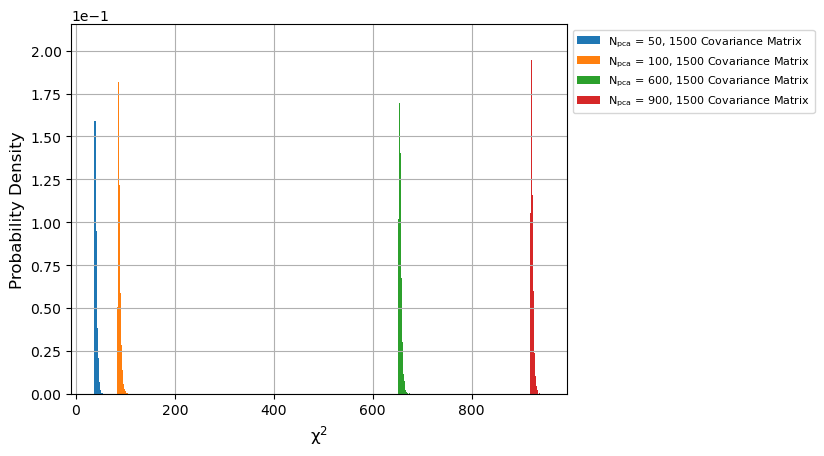

In [15]:
## Plots the chi-squared distributions for different N_pca using the same covariance matrix 
## with 1500 data vectors 

for chi2_dist, label in zip([chi2_50_b, chi2_100_b, chi2_600_b, chi2_900_b], 
                            [r"$\mathrm{N_{pca}}$" + " = 50, 1500 Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 100, 1500 Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 600, 1500 Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 900, 1500 Covariance Matrix"]):
    plt.hist(chi2_dist, bins = "fd", density = True, label = label)
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
plt.grid()
plt.show()

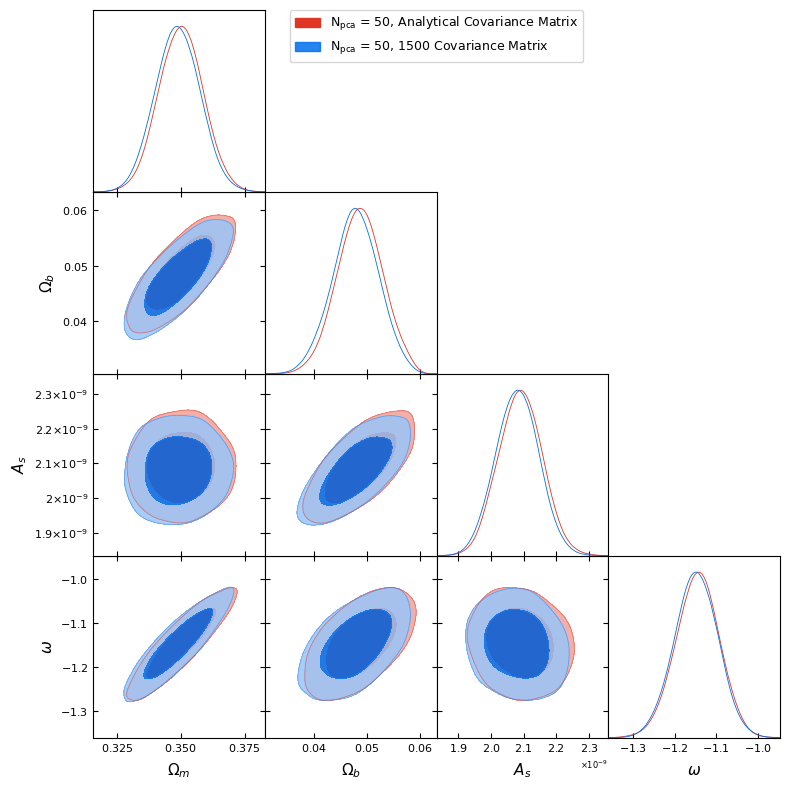

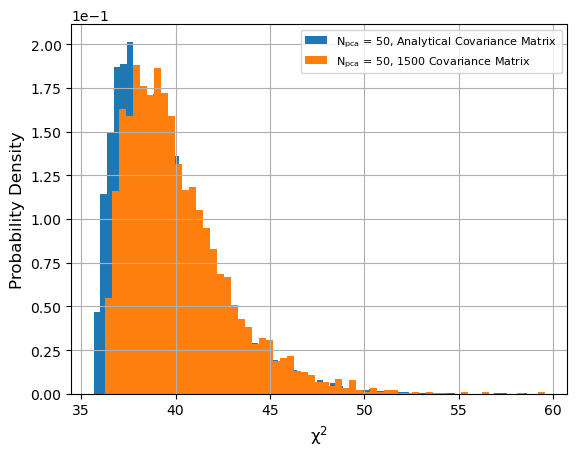

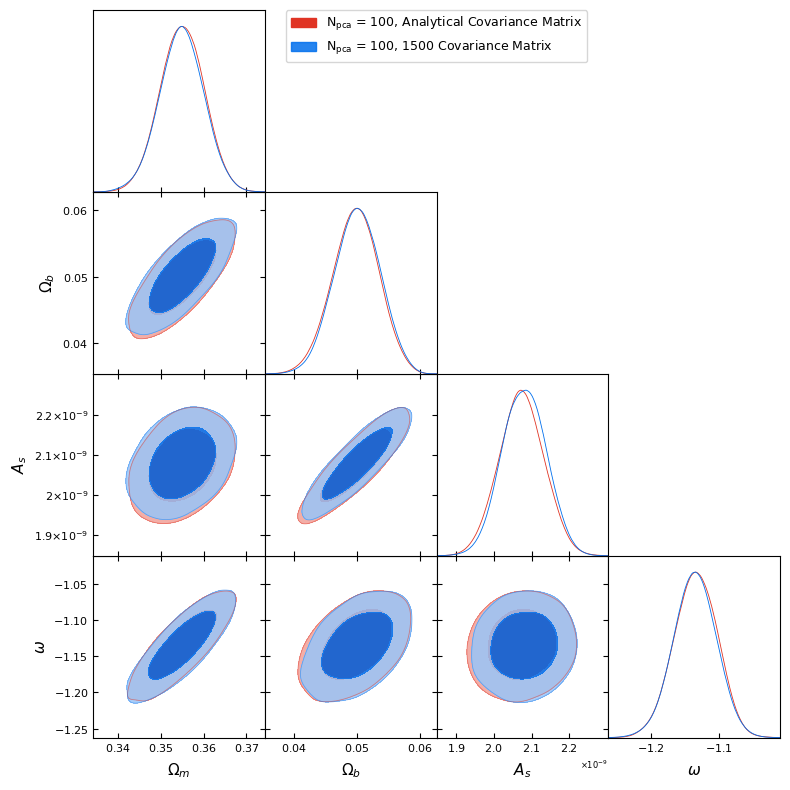

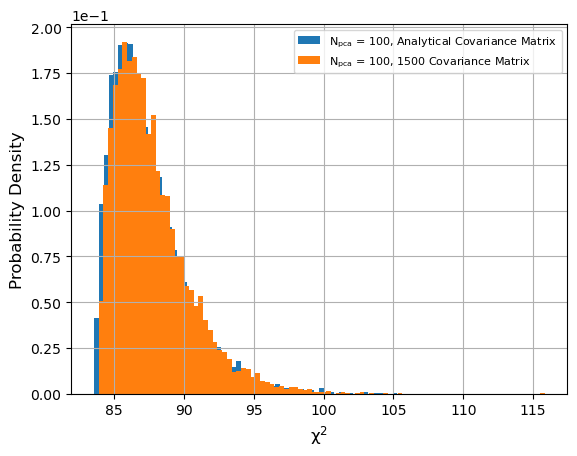

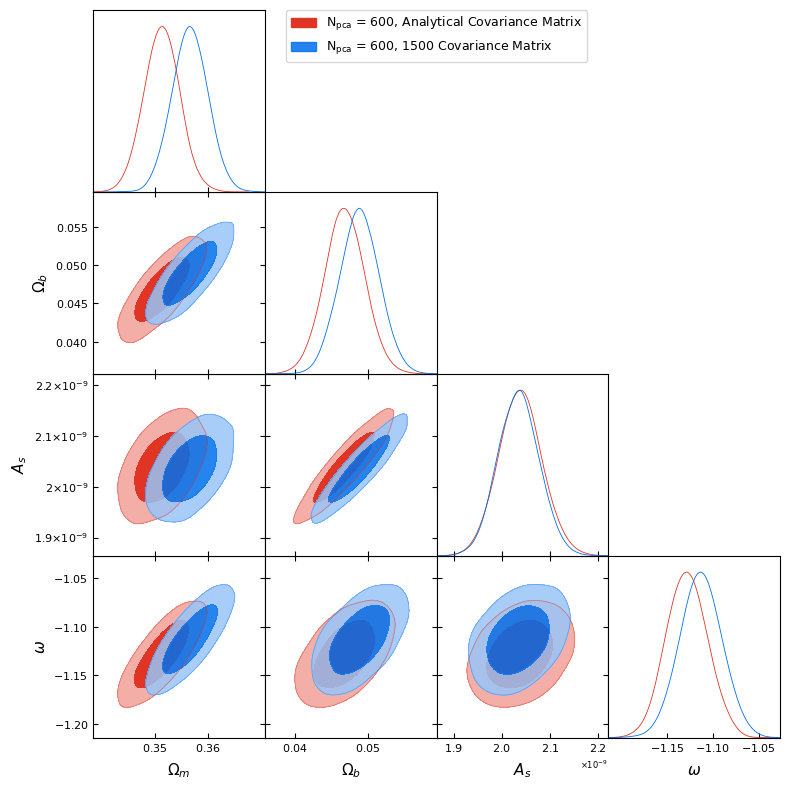

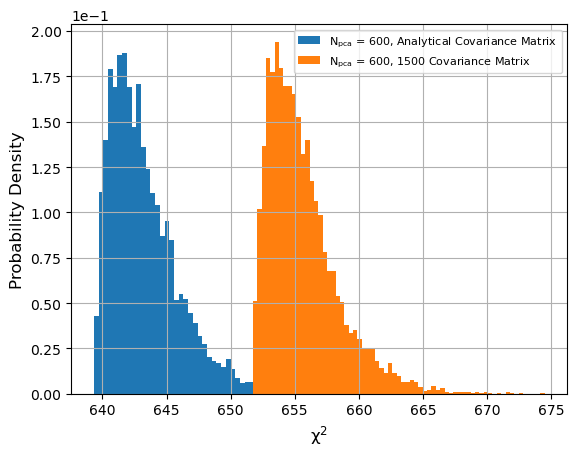

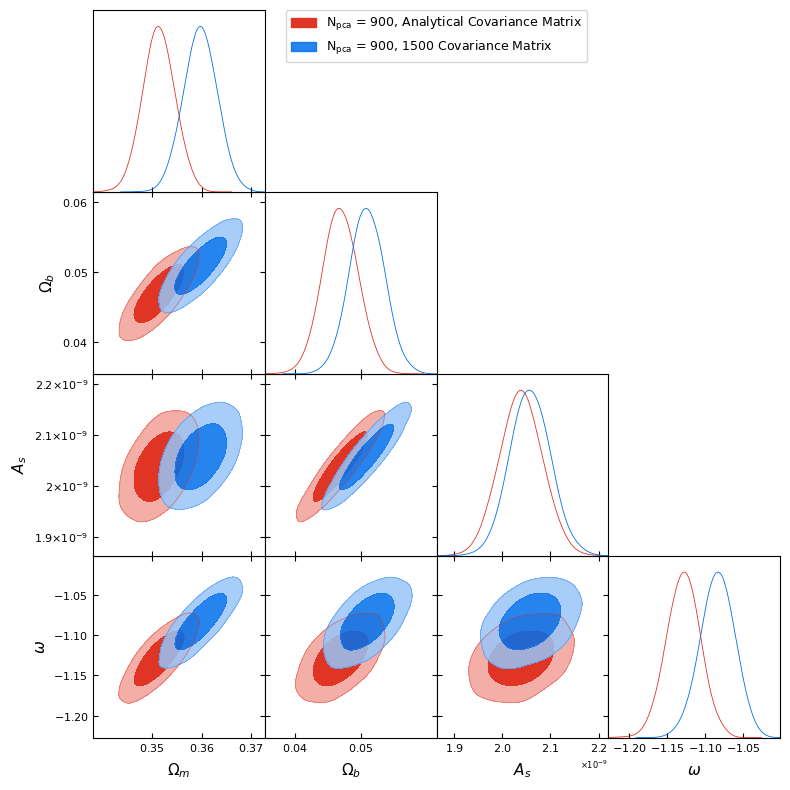

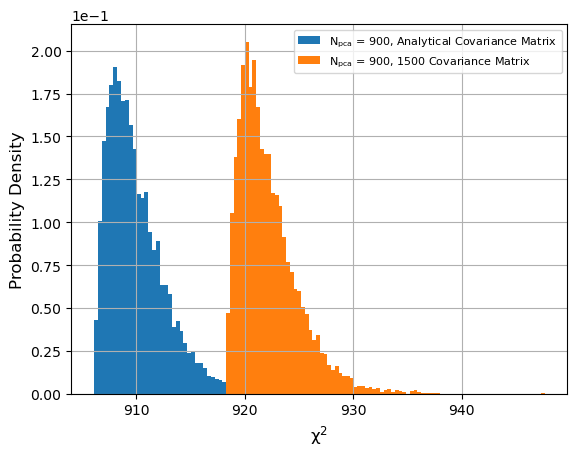

In [17]:
## Plots the posterior and chi-squared distributions for a given number of PCA elements 

for samples, chi2_dists, labels in zip([[sample_1_a, sample_1_b], 
                                        [sample_2_a, sample_2_b], 
                                        [sample_3_a, sample_3_b],
                                        [sample_4_a, sample_4_b]], 
                                       [[chi2_50_a, chi2_50_b], 
                                        [chi2_100_a, chi2_100_b], 
                                        [chi2_600_a, chi2_600_b],
                                        [chi2_900_a, chi2_900_b]], 
                                       [[r"$\mathrm{N_{pca}}$" + " = 50, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 50, 1500 Covariance Matrix"], 
                                        [r"$\mathrm{N_{pca}}$" + " = 100, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 100, 1500 Covariance Matrix"], 
                                        [r"$\mathrm{N_{pca}}$" + " = 600, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 600, 1500 Covariance Matrix"],
                                        [r"$\mathrm{N_{pca}}$" + " = 900, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 900, 1500 Covariance Matrix"]]):
    g.triangle_plot([samples[0], samples[1]], filled = True)
    plt.show()
    plt.hist(chi2_dists[0], bins = "fd", density = True, label = labels[0])
    plt.hist(chi2_dists[1], bins = "fd", density = True, label = labels[1])
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
    plt.grid()
    plt.show()

As can be seen from the figures above, a larger number of PCA elements results in smaller error bars/tighter parameter constraints. This trend is seen in parts a and b. Also, the larger N_pca runs (600 and 900) using the analytical covariance matrix produce nearly the same parameter constraints. Interestingly, when N_pca is small (50 or 100), the analytical and 1500 covariance matrices result in very similar posterior and chi-squared distributions. As an aside, the 1500 covariance matrix is not as accurate as the analytical covariance matrix (or even the 3000 covariance matrix). This trend does not hold for larger N_pca. In Assignment 2, we saw that when N_pca was very small, we had much less constraining power compared to the Fisher analysis method. Essentially, there comes a point where N_pca is too small and, subsequently, too much information is lost. So, it is not unreasonable that when N_pca is small, we get similar results between the analytical and 1500 covariance matrices as the constraints will be poor regardless. 

Thus, the takeaway is that even if we use an analytical covariance matrix or a covariance matrix with many data vectors, we will still get inaccurate parameter constraints if N_pca is too small. Here, "too small" seems to be 100 PCA elements, although this threshold cannot be verified since we are limited by the number of MCMC runs we can execute.

#### Question 4:

Here, we repeated Question 3 using the noise-free reference model. In other words, we used "reference_model.npy" instead of "reference_model_noise.npy." 

MCMC results using the **NOISE-FREE** reference model:

In [15]:
flat_samples_50_a = np.load("Q4_50_flat_samples.npy")
log_prob_samples_50_a = np.load("Q4_50_log_prob_samples.npy")
flat_samples_100_a = np.load("Q4_100_flat_samples.npy")
log_prob_samples_100_a = np.load("Q4_100_log_prob_samples.npy")
flat_samples_600_a = np.load("Q4_600_flat_samples.npy")
log_prob_samples_600_a = np.load("Q4_600_log_prob_samples.npy")
flat_samples_900_a = np.load("Q4_900_flat_samples.npy")
log_prob_samples_900_a = np.load("Q4_900_log_prob_samples.npy")

sample_1_a = MCSamples(samples = flat_samples_50_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 50, Analytical Covariance Matrix")
sample_2_a = MCSamples(samples = flat_samples_100_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 100, Analytical Covariance Matrix")
sample_3_a = MCSamples(samples = flat_samples_600_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 600, Analytical Covariance Matrix")
sample_4_a = MCSamples(samples = flat_samples_900_a, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 900, Analytical Covariance Matrix")
                         
chi2_50_a = -2 * log_prob_samples_50_a
chi2_100_a = -2 * log_prob_samples_100_a
chi2_600_a = -2 * log_prob_samples_600_a
chi2_900_a = -2 * log_prob_samples_900_a

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


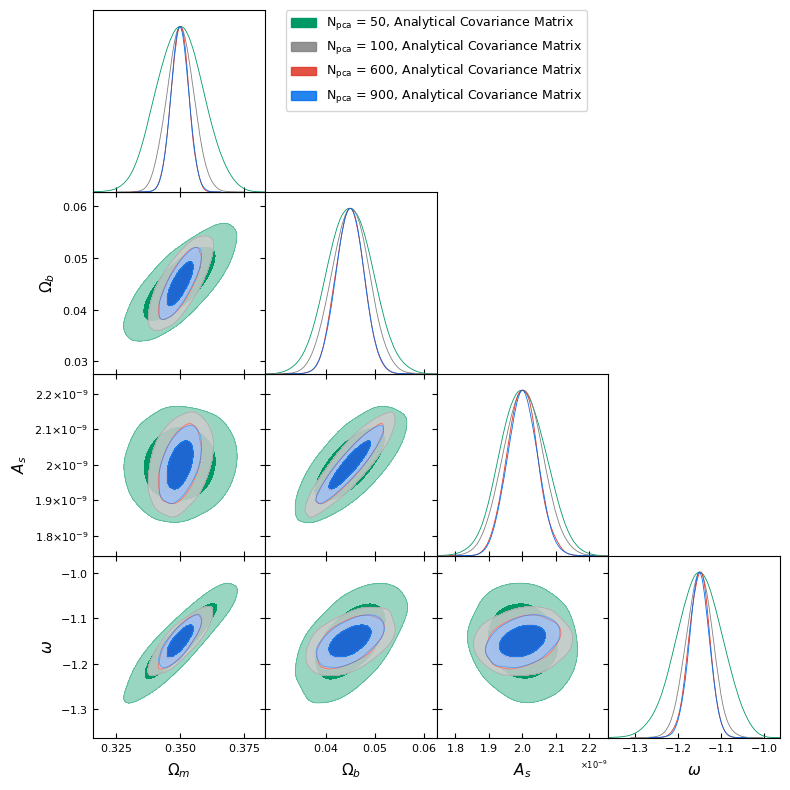

In [16]:
# Plots the posterior distributions for different N_pca using the same analytical covariance 
# matrix and noise-free reference model 
g.triangle_plot([sample_1_a, sample_2_a, sample_3_a, sample_4_a], filled = True)

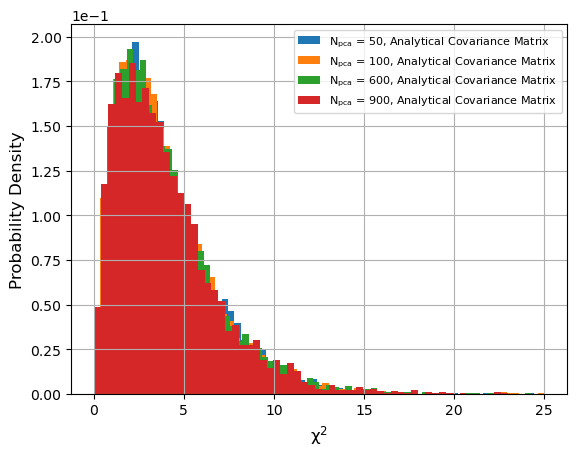

In [17]:
## Plots the chi-squared distributions for different N_pca using the same analytical covariance 
## matrix and noise-free reference model 

for chi2_dist, label in zip([chi2_50_a, chi2_100_a, chi2_600_a, chi2_900_a], 
                            [r"$\mathrm{N_{pca}}$" + " = 50, Analytical Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 100, Analytical Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 600, Analytical Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 900, Analytical Covariance Matrix"]):
    plt.hist(chi2_dist, bins = "fd", density = True, label = label)
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
plt.grid()
plt.show()

Additional remark: since we're using a noise-free reference model, the degrees of freedom essentially come from varying our 4 cosmological parameters. So, the chi-squared distributions are *significantly* shifted down the x-axis as we have way fewer degrees of freedom. 

In [18]:
flat_samples_50_b = np.load("Q4_50_hartlap_flat_samples.npy")
log_prob_samples_50_b = np.load("Q4_50_hartlap_log_prob_samples.npy")
flat_samples_100_b = np.load("Q4_100_hartlap_flat_samples.npy")
log_prob_samples_100_b = np.load("Q4_100_hartlap_log_prob_samples.npy")
flat_samples_600_b = np.load("Q4_600_hartlap_flat_samples.npy")
log_prob_samples_600_b = np.load("Q4_600_hartlap_log_prob_samples.npy")
flat_samples_900_b = np.load("Q4_900_hartlap_flat_samples.npy")
log_prob_samples_900_b = np.load("Q4_900_hartlap_log_prob_samples.npy")

sample_1_b = MCSamples(samples = flat_samples_50_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 50, 1500 Covariance Matrix")
sample_2_b = MCSamples(samples = flat_samples_100_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 100, 1500 Covariance Matrix")
sample_3_b = MCSamples(samples = flat_samples_600_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 600, 1500 Covariance Matrix")
sample_4_b = MCSamples(samples = flat_samples_900_b, names = names, labels = names, 
                     label = r"$\mathrm{N_{pca}}$" + " = 900, 1500 Covariance Matrix")
                         
chi2_50_b = -2 * log_prob_samples_50_b
chi2_100_b = -2 * log_prob_samples_100_b
chi2_600_b = -2 * log_prob_samples_600_b
chi2_900_b = -2 * log_prob_samples_900_b

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


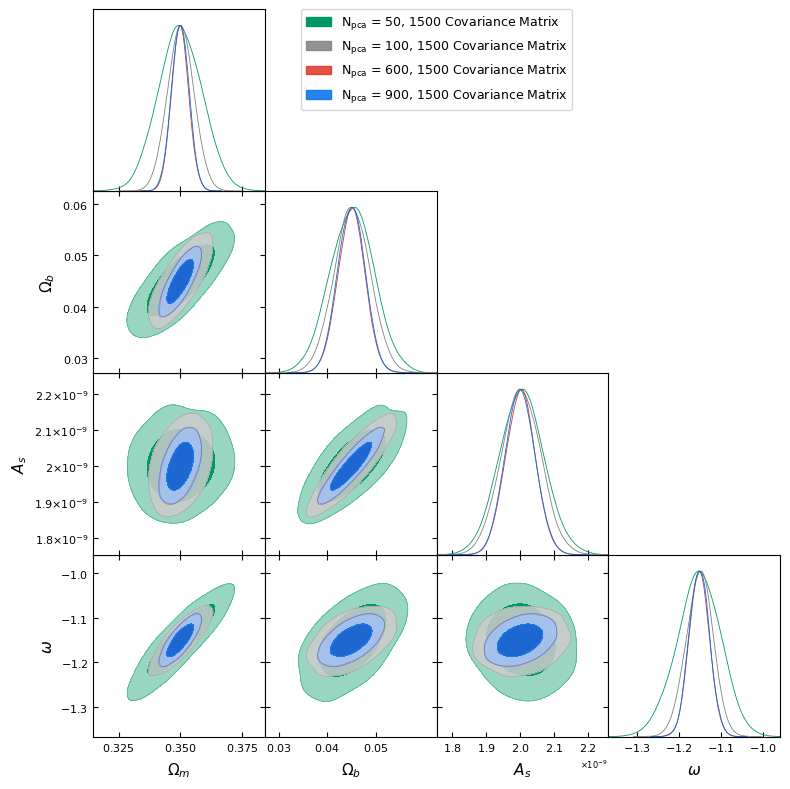

In [19]:
# Plots the posterior distributions for different N_pca using the same covariance matrix 
# with 1500 data vectors and noise-free reference model 
g.triangle_plot([sample_1_b, sample_2_b, sample_3_b, sample_4_b], filled = True)

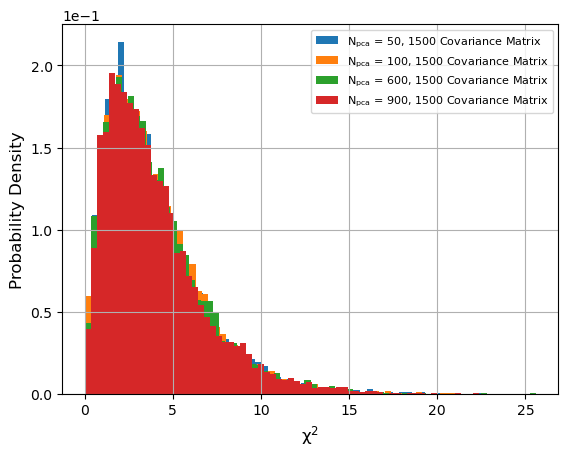

In [20]:
## Plots the chi-squared distributions for different N_pca using the same covariance matrix 
## with 1500 data vectors and noise-free reference model

for chi2_dist, label in zip([chi2_50_b, chi2_100_b, chi2_600_b, chi2_900_b], 
                            [r"$\mathrm{N_{pca}}$" + " = 50, 1500 Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 100, 1500 Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 600, 1500 Covariance Matrix", 
                             r"$\mathrm{N_{pca}}$" + " = 900, 1500 Covariance Matrix"]):
    plt.hist(chi2_dist, bins = "fd", density = True, label = label)
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
plt.grid()
plt.show()

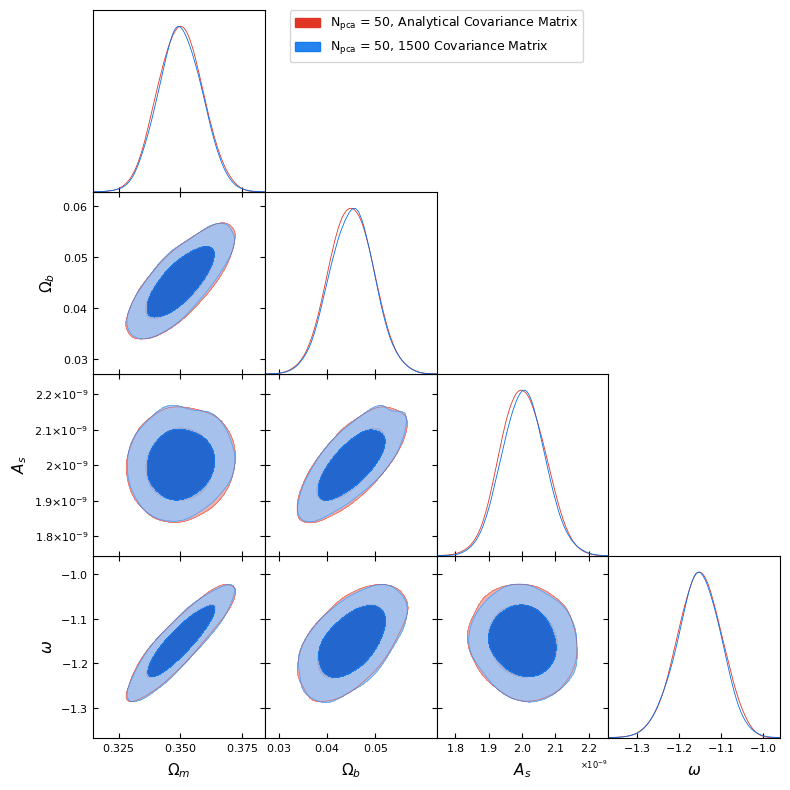

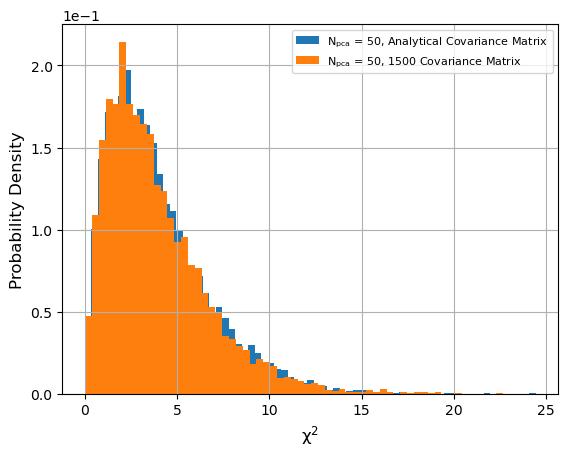

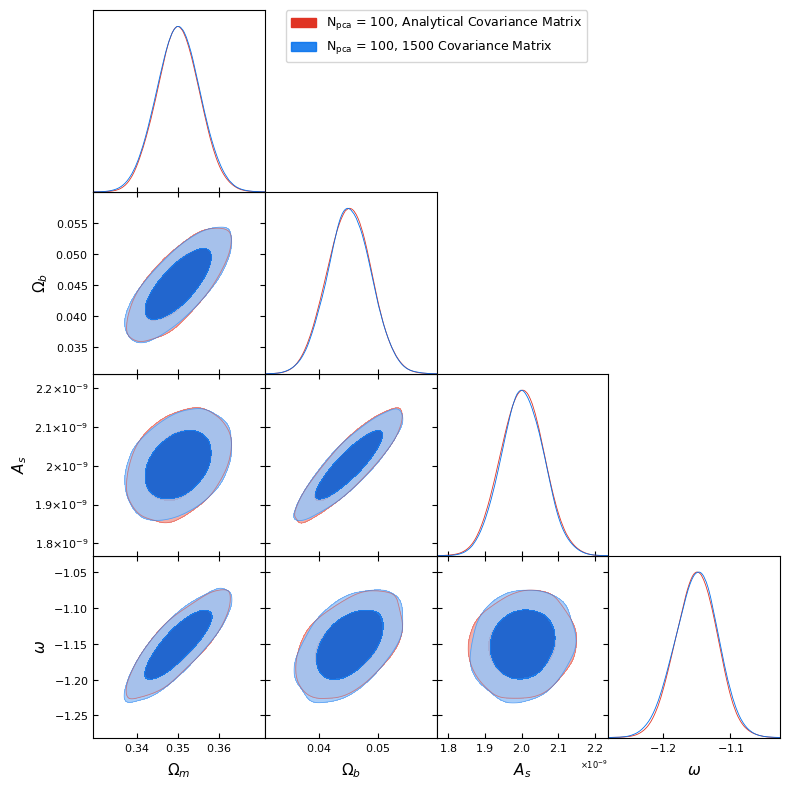

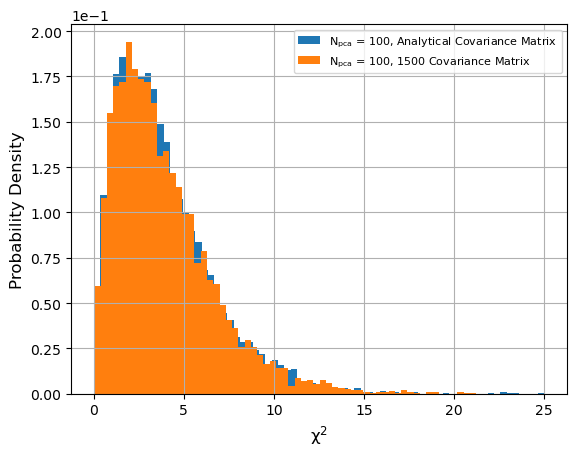

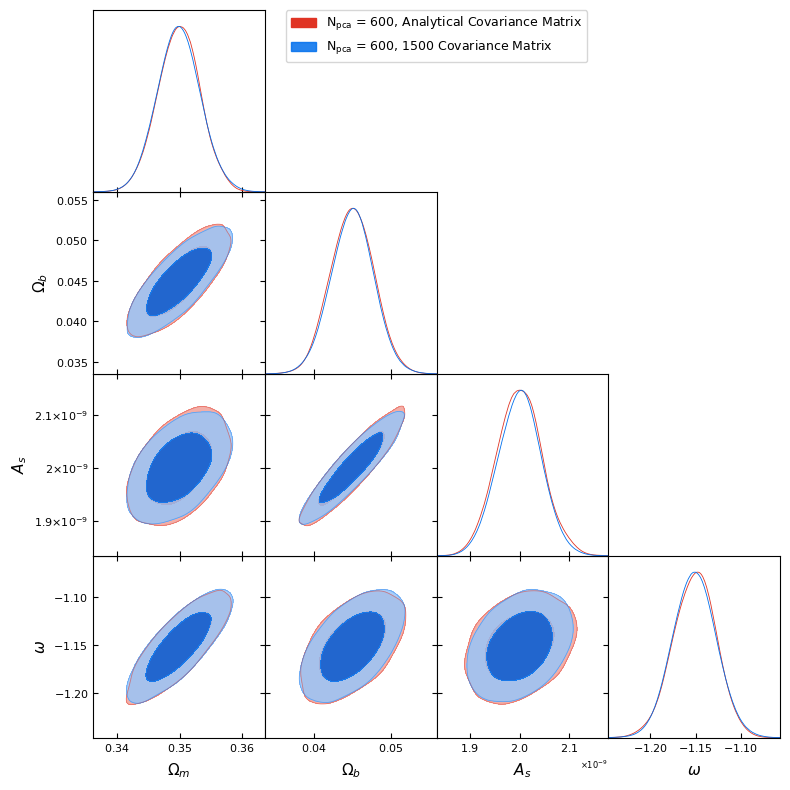

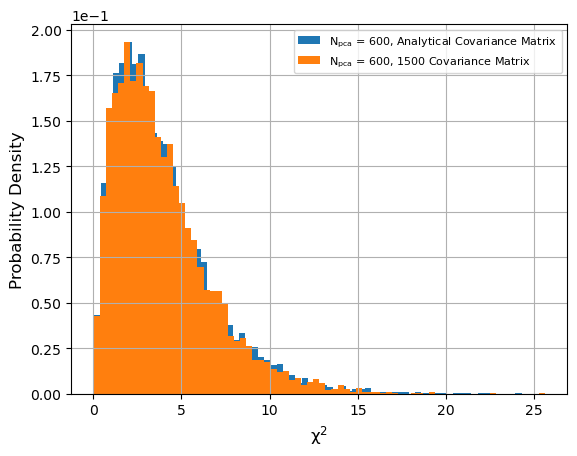

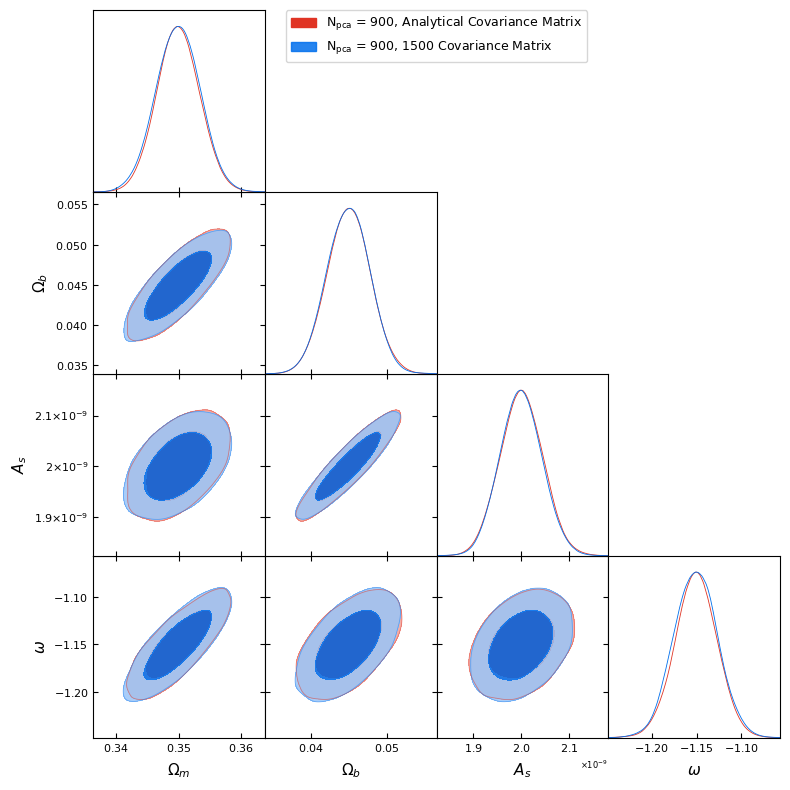

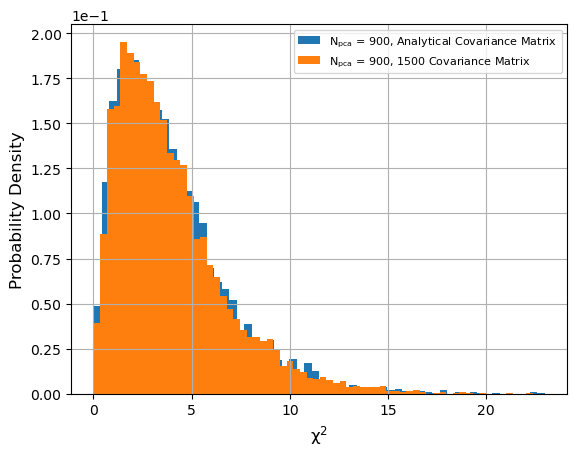

In [21]:
## Plots the posterior and chi-squared distributions for a given number of PCA elements using the
## noise-free reference model 

for samples, chi2_dists, labels in zip([[sample_1_a, sample_1_b], 
                                        [sample_2_a, sample_2_b], 
                                        [sample_3_a, sample_3_b],
                                        [sample_4_a, sample_4_b]], 
                                       [[chi2_50_a, chi2_50_b], 
                                        [chi2_100_a, chi2_100_b], 
                                        [chi2_600_a, chi2_600_b],
                                        [chi2_900_a, chi2_900_b]], 
                                       [[r"$\mathrm{N_{pca}}$" + " = 50, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 50, 1500 Covariance Matrix"], 
                                        [r"$\mathrm{N_{pca}}$" + " = 100, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 100, 1500 Covariance Matrix"], 
                                        [r"$\mathrm{N_{pca}}$" + " = 600, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 600, 1500 Covariance Matrix"],
                                        [r"$\mathrm{N_{pca}}$" + " = 900, Analytical Covariance Matrix", 
                                         r"$\mathrm{N_{pca}}$" + " = 900, 1500 Covariance Matrix"]]):
    g.triangle_plot([samples[0], samples[1]], filled = True)
    plt.show()
    plt.hist(chi2_dists[0], bins = "fd", density = True, label = labels[0])
    plt.hist(chi2_dists[1], bins = "fd", density = True, label = labels[1])
    plt.xlabel(r"$\mathrm{\chi^2}$", fontsize = 12)
    plt.ylabel("Probability Density", fontsize = 12)
    plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0, 0))
    plt.legend(bbox_to_anchor = (1, 1), fontsize = 8)
    plt.grid()
    plt.show()

By using the noise-free reference model, all the posterior distributions are centered at the same parameter values and the chi-squared distributions overlay each other. This result holds for the analytical and 1500 covariance matrices, although the posterior distributions from the analytical covariance matrix look a bit more consistent. Just like what we saw in Question 3, as N_pca increases, the parameter constraints get tighter/the posterior distributions narrow. Also, regardless of N_pca, the results from the analytical and 1500 covariance matrices agree with each other. This was only the case for small N_pca in Question 3. 

#### 4a)

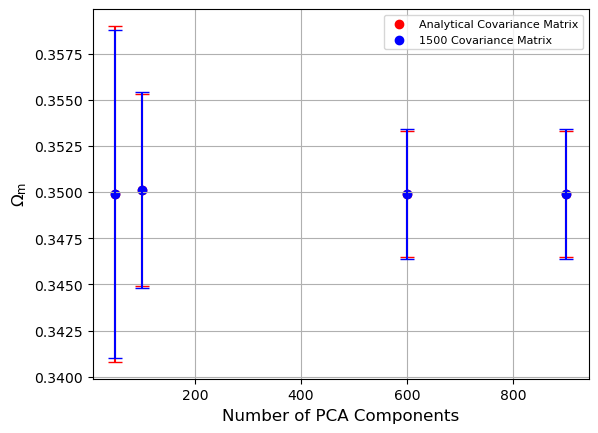

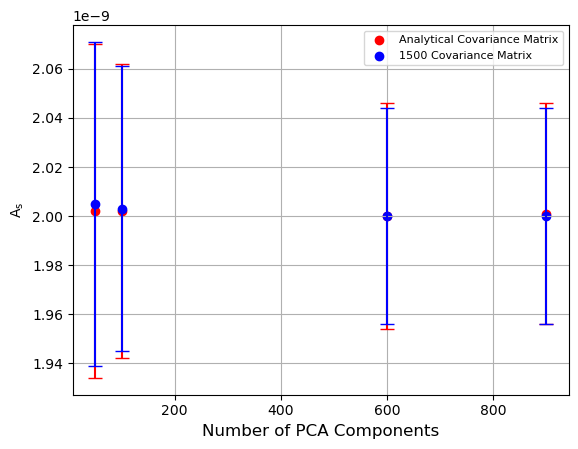

The variance of the error in omega_m for different N_pca is 4.86e-06 for the 1500 covariance matrix
The variance of the error in As for different N_pca is 8.900000000000001e-23 for the 1500 covariance matrix


In [30]:
# Defines the constraints for omega_m using the analytical covariance matrix 
omega_m_analytical = [0.3499, 0.3501, 0.3499, 0.3499]
# Defines the error associated with omega_m 
omega_m_analytical_err = [0.0091, 0.0052, 0.0034, 0.0034]
As_analytical = [2.002e-9, 2.002e-9, 2e-9, 2.001e-9]
As_analytical_err = [0.068e-9, 0.06e-9, 0.046e-9, 0.045e-9]

# Defines the constraints for omega_m using the covariance matrix from 1500 data vectors 
omega_m_1500 = [0.3499, 0.3501, 0.3499, 0.3499]
omega_m_1500_err = [0.0089, 0.0053, 0.0035, 0.0035]
As_1500 = [2.005e-9, 2.003e-9, 2e-9, 2e-9]
As_1500_err = [0.066e-9, 0.058e-9, 0.044e-9, 0.044e-9]

N_pca = [50, 100, 600, 900]

## Plots the constraints on omega_m and As as a function of the number of PCA elements

plt.scatter(N_pca, omega_m_analytical, color = "red", label = "Analytical Covariance Matrix")
plt.errorbar(N_pca, omega_m_analytical, yerr = omega_m_analytical_err, linestyle = " ", 
             capsize = 5, color = "red")
plt.scatter(N_pca, omega_m_1500, color = "blue", label = "1500 Covariance Matrix")
plt.errorbar(N_pca, omega_m_1500, yerr = omega_m_1500_err, linestyle = " ", capsize = 5, 
             color = "blue")
plt.xlabel("Number of PCA Components", fontsize = 12)
plt.ylabel(r"$\mathrm{\Omega_m}$", fontsize = 12)
plt.legend(loc = "best", fontsize = 8)
plt.grid()
plt.show()

plt.scatter(N_pca, As_analytical, color = "red", label = "Analytical Covariance Matrix")
plt.errorbar(N_pca, As_analytical, yerr = As_analytical_err, linestyle = " ", capsize = 5, 
             color = "red")
plt.scatter(N_pca, As_1500, color = "blue", label = "1500 Covariance Matrix")
plt.errorbar(N_pca, As_1500, yerr = As_1500_err, linestyle = " ", capsize = 5, 
             color = "blue")
plt.xlabel("Number of PCA Components", fontsize = 12)
plt.ylabel(r"$\mathrm{A_s}$")
plt.legend(loc = "best", fontsize = 8)
plt.grid()
plt.show()

# Computes the variance of the error in omega_m for the 1500 covariance matrix
omega_m_1500_err_var = np.var(omega_m_1500_err) 
# Computes the variance of the error in As for the 1500 covariance matrix 
As_1500_err_var = np.var(As_1500_err)

print("The variance of the error in omega_m for different N_pca is", omega_m_1500_err_var, 
      "for the 1500 covariance matrix")
print("The variance of the error in As for different N_pca is", As_1500_err_var, 
      "for the 1500 covariance matrix")

From the plots above, we see that the best fit parameter values from the analytical and 1500 covariance matrices are very close to each other, and these values do not really change as N_pca increases. However, we can see that the error bars get smaller as N_pca increases, which is precisely what we observed in the posterior distributions previously shown. That being said, there is some point where regardless of how large N_pca is, the error bars remain the same size. This seems to occur around N_pca = 600. 

Note: 600 PCA elements appears to be a "sweet spot" where we can decompress some of our data/lose some information and still get nearly identical parameter constraints as if the data decompression was not performed.

#### 4b)

To verify that the answer in 4a is robust, multiple MCMC chains were run using the 1500 covariance matrix, 600 PCA elements, and the noise-free reference model. The only difference between scripts is that each had a different random seed.  

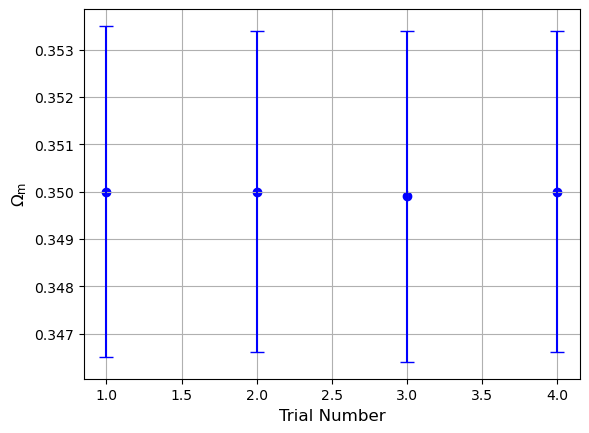

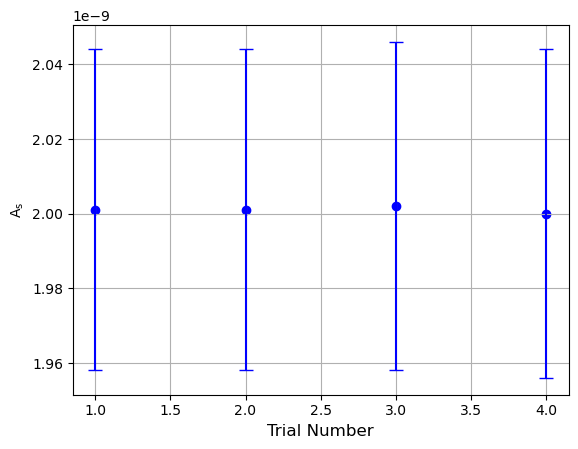

The variance of the error in omega_m is 2.5000000000000133e-09
The variance of the error in As is 2.500000000000015e-25


In [31]:
omega_m_1500 = [0.35, 0.35, 0.3499, 0.35]
omega_m_1500_err = [0.0035, 0.0034, 0.0035, 0.0034]
As_1500 = [2.001e-9, 2.001e-9, 2.002e-9, 2e-9]
As_1500_err = [0.043e-9, 0.043e-9, 0.044e-9, 0.044e-9]

## Plots the constraints on omega_m and As as a function of trial number 

plt.scatter(range(1, 5), omega_m_1500, color = "blue")
plt.errorbar(range(1, 5), omega_m_1500, yerr = omega_m_1500_err, linestyle = " ", capsize = 5, 
             color = "blue")
plt.xlabel("Trial Number", fontsize = 12)
plt.ylabel(r"$\mathrm{\Omega_m}$", fontsize = 12)
plt.grid()
plt.show()

plt.scatter(range(1, 5), As_1500, color = "blue")
plt.errorbar(range(1, 5), As_1500, yerr = As_1500_err, linestyle = " ", capsize = 5, 
             color = "blue")
plt.xlabel("Trial Number", fontsize = 12)
plt.ylabel(r"$\mathrm{A_s}$")
plt.grid()
plt.show()

omega_m_1500_err_var = np.var(omega_m_1500_err) 
As_1500_err_var = np.var(As_1500_err)

print("The variance of the error in omega_m is", omega_m_1500_err_var)
print("The variance of the error in As is", As_1500_err_var)

As can be seen from the plots above, different MCMC runs result in very similar parameter constraints; the data points are almost the same and the error bars are essentially the same size. Also, the variances of the errors/standard deviations are significantly smaller (roughly 3 orders of magnitude) for different trials with a fixed N_pca compared to the variances over different N_pca. So, the trend of error bars decreasing in size as N_pca increases is not some artifact of MCMC producing different results for different realizations since the variances of the errors at a fixed N_pca are comparatively small.

Therefore, our answer in 4a is, indeed, robust. To make 4a more reliable, one can perform multiple MCMC runs and average over their results.